In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
sys.path.append('../common')
import collect_dem

%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
font_size = 18
rc('font', size=font_size)
rc('axes', titlesize=font_size)
%config InlineBackend.figure_format = 'retina'

In [2]:
import scipy.sparse.csgraph as graph
import scipy.sparse
def tri_connectivity_graph(tris):
    n_tris = tris.shape[0]
    touching = [[] for i in range(np.max(tris) + 1)]
    for i in range(n_tris):
        for d in range(3):
            touching[tris[i,d]].append(i)
            
    rows = []
    cols = []
    for i in range(len(touching)):
        for row in touching[i]:
            for col in touching[i]:
                rows.append(row)
                cols.append(col)
    rows = np.array(rows)
    cols = np.array(cols)
    connectivity = scipy.sparse.coo_matrix((np.ones(rows.shape[0]), (rows, cols)), shape = (n_tris, n_tris))
    return connectivity
    
def get_connected_components(tris):
    return graph.connected_components(tri_connectivity_graph(tris))

def find_free_edges(tris):
    edges = dict()
    for i, t in enumerate(tris):
        for d in range(3):
            pt1_idx = t[d]
            pt2_idx = t[(d + 1) % 3]
            if pt1_idx > pt2_idx:
                pt2_idx,pt1_idx = pt1_idx,pt2_idx
            pt_pair = (pt1_idx, pt2_idx)
            edges[pt_pair] = edges.get(pt_pair, []) + [(i, d)]

    free_edges = []
    for k,e in edges.items():
        if len(e) > 1:
            continue
        free_edges.append(e[0])

    return free_edges

def get_boundary_loop(m):
    which_comp = get_connected_components(m[1])[1]
    n_surfaces = np.unique(which_comp).shape[0]
    orderings = []
    for surf_idx in range(2):
        tri_subset = m[1][which_comp == surf_idx]
        free_edges = find_free_edges(tri_subset)
        pt_to_pt = [
            (tri_subset[tri_idx, edge_idx], tri_subset[tri_idx, (edge_idx + 1) % 3])
            for tri_idx, edge_idx in free_edges
        ]

        pts_to_edges = dict()
        for i, e in enumerate(pt_to_pt):
            for lr in [0,1]:
                pts_to_edges[e[lr]] = pts_to_edges.get(e[lr], []) + [i]

        for k,v in pts_to_edges.items():
            assert(len(v) == 2)

        ordering = [pt_to_pt[0][0], pt_to_pt[0][1]]
        looped = False
        while not looped:
            pt_idx = ordering[-1]
            prev_pt_idx = ordering[-2]
            for e_idx in pts_to_edges[pt_idx]:
                edge = pt_to_pt[e_idx]
                if edge[0] == prev_pt_idx or edge[1] == prev_pt_idx:
                    continue
                if edge[0] == pt_idx:
                    ordering.append(edge[1])
                else:
                    ordering.append(edge[0])
            if ordering[-1] == ordering[0]:
                looped = True
        orderings.append(ordering)
    return orderings

def remove_unused_pts(m):
    referenced_pts = np.unique(m[1])
    new_pts = m[0][referenced_pts,:]
    new_indices = np.empty(m[0].shape[0], dtype = np.int64)
    new_indices[referenced_pts] = np.arange(referenced_pts.shape[0])
    new_tris = new_indices[m[1]]
    return (new_pts, new_tris)

def get_dem_bounds(lonlat_pts):
    minlat = np.min(lonlat_pts[:,1])
    minlon = np.min(lonlat_pts[:,0])
    maxlat = np.max(lonlat_pts[:,1])
    maxlon = np.max(lonlat_pts[:,0])
    latrange = maxlat - minlat
    lonrange = maxlon - minlon
    bounds = (
        minlat - latrange * 0.1,
        minlon - lonrange * 0.1,
        maxlat + latrange * 0.1,
        maxlon + lonrange * 0.1
    )
    return bounds

def get_pt_elevations(lonlat_pts, zoom, n_interp = 100):
    bounds = get_dem_bounds(lonlat_pts)
    LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)
    return scipy.interpolate.griddata(
        (LON, LAT), DEM, (lonlat_pts[:,0], lonlat_pts[:,1])
    )

In [282]:
#bounds = 29.361572, 98.207583, 33.579870, 106.743077
zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300
#proj = 'ellps'

In [283]:
from tectosaur.mesh.modify import remove_duplicate_pts
lon,lat,z,tris = np.load('wenchuan_fault_surf.npy', encoding = 'latin1')
pts = np.vstack((lon,lat,z)).T
pts, tris = remove_duplicate_pts((pts, tris))
which_comp = get_connected_components(tris)[1]

In [284]:
#remove the detachment
average_depth = np.zeros(3)
average_depth = np.mean(pts[tris,2], axis = 1)
component_depth = np.array([np.mean(average_depth[which_comp == d]) for d in range(3)])
detachment_component = np.where(component_depth < -21000)[0][0]
nondetachment_tris = tris[np.where(which_comp != detachment_component)[0]]

In [285]:
#remove unused pts
new_pts, new_tris = remove_unused_pts((pts, nondetachment_tris))

In [286]:
fault_pts = collect_dem.project(new_pts[:,0], new_pts[:,1], new_pts[:,2], proj)
fault_m = (fault_pts, new_tris)

48R


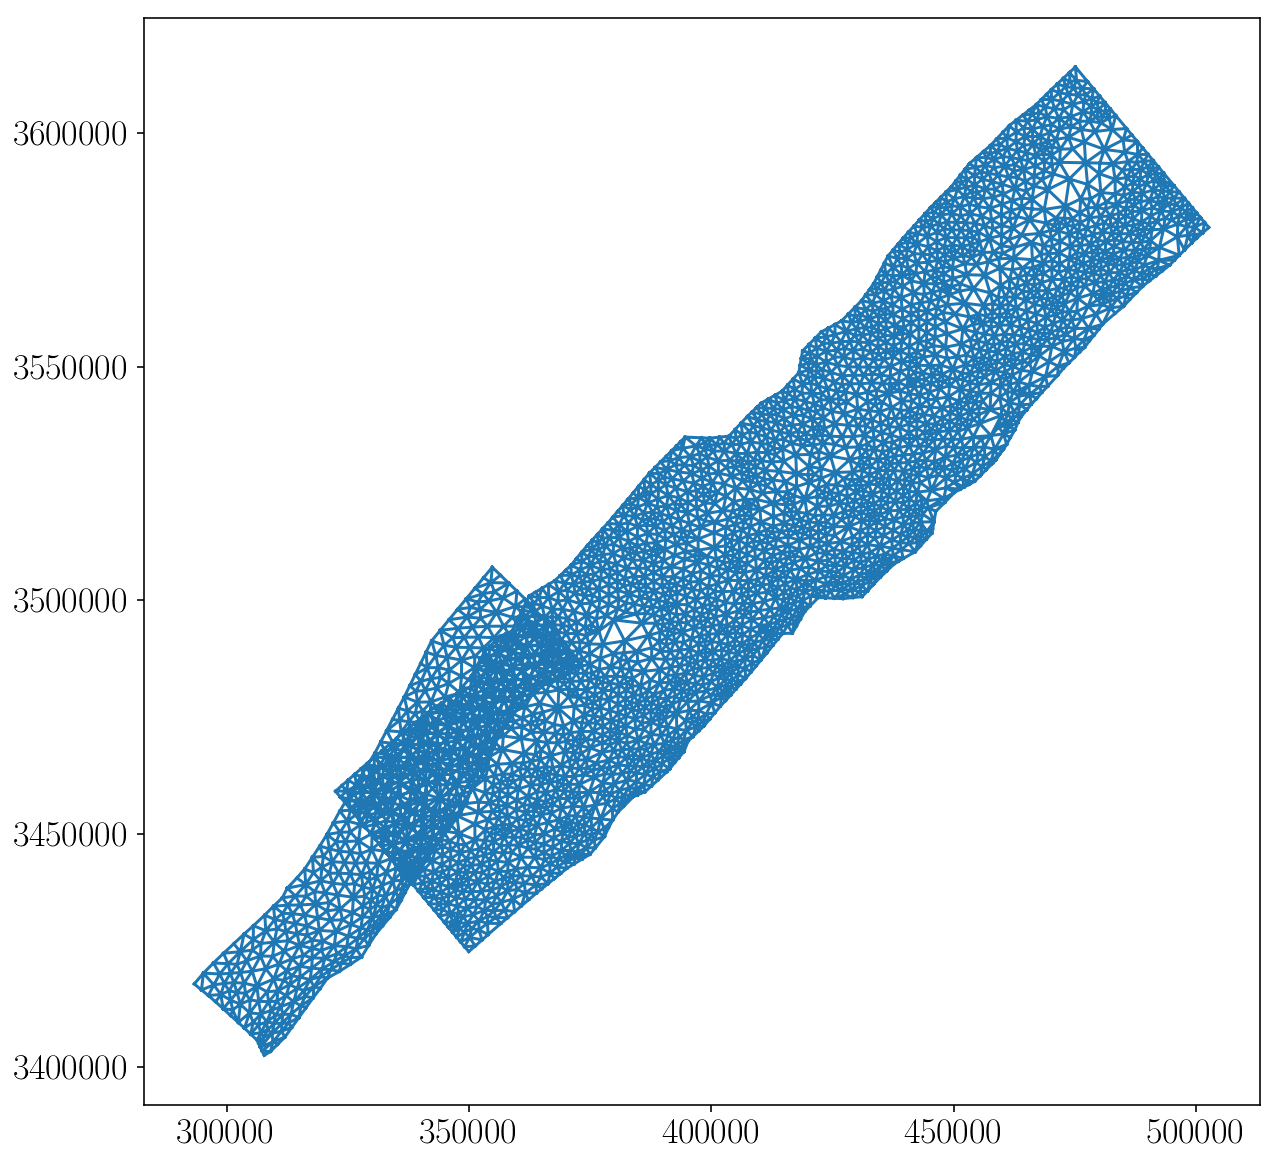

In [287]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [288]:
import meshio
meshio.write('/tmp/dense_fault.msh', fault_m[0], {'triangle': fault_m[1]})

In [289]:
code = """
Merge "dense_fault.msh";
RefineMesh;
CreateTopology;

ll[] = Line "*";
For j In {0 : #ll[]-1}
  Compound Line(newl) = ll[j];
EndFor
ss[] = Surface "*";
s = news;
For i In {0 : #ss[]-1}
  Compound Surface(s+i) = ss[i];
EndFor

Field[1] = MathEval;
Field[1].F = "10000.0";
Background Field = 1;

Mesh.RemeshAlgorithm = 1;
Mesh.RemeshParametrization = 7;
Geometry.HideCompounds = 1;
"""
import pygmsh
geom = pygmsh.built_in.Geometry()
geom.add_raw_code(code)
simplify_pts, simplify_cells, point_data, cell_data, field_data = pygmsh.generate_mesh(geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0)

Info    : Running 'gmsh -2 -bin /tmp/tmprn3rfaxo.geo -o /tmp/tmp6qkv4oud.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Wed Nov  1 11:10:01 2017
Info    : Reading '/tmp/tmprn3rfaxo.geo'...
Info    : Reading '/tmp/dense_fault.msh'...
Info    : 3575 vertices
Info    : 6732 elements
Info    : Done reading '/tmp/dense_fault.msh'
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : Meshing surface 0 order 2
Info    : Finalized high order topology of periodic connections
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.104272
Info    : Done meshing order 2 (0.024026 s)
Info    : Done refining mesh (0.039626 s)
Info    : Creating topology from mesh...
Info    : Removing duplicate mesh vertices...
Info    : Found 0 duplicate vertices 
Info    : No duplicate vertices found
Info    : Creating the geometry of discrete curves
Info    : Done creating topology from mesh (0.19783 s)
Info    : Done reading '/tmp/tmprn3r

In [290]:
simplify_tris = simplify_cells['triangle'][cell_data['triangle']['geometrical'] > 2]
fault_m = remove_unused_pts((simplify_pts, simplify_tris))
fault_m[0].shape[0], fault_m[1].shape[0]

(237, 386)

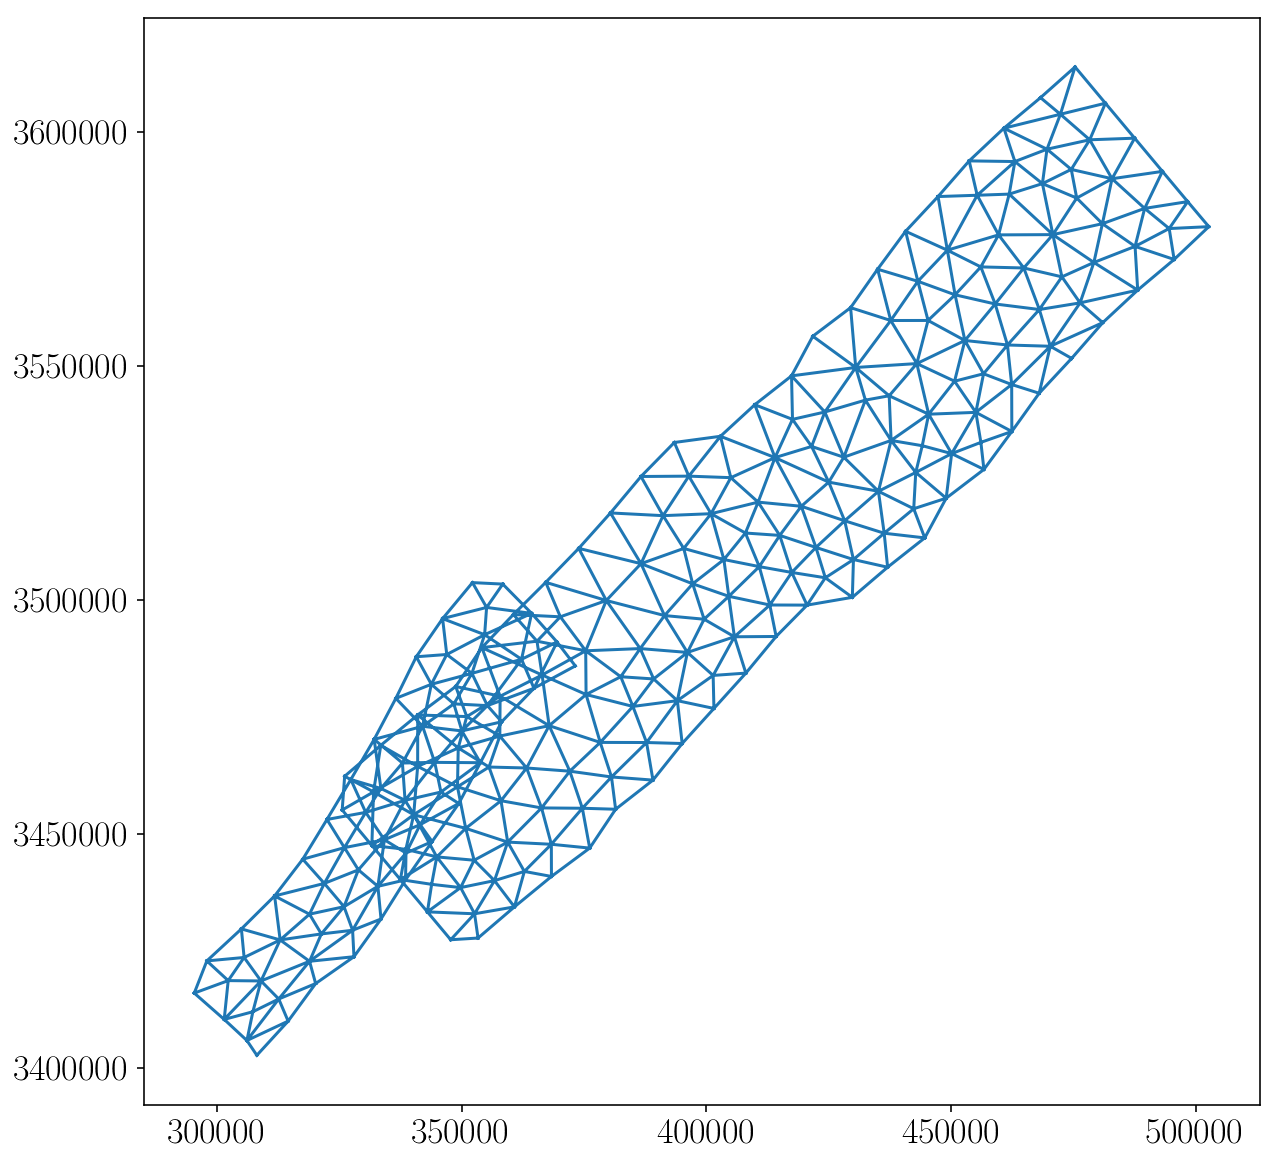

In [291]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [292]:
orderings = get_boundary_loop(fault_m)

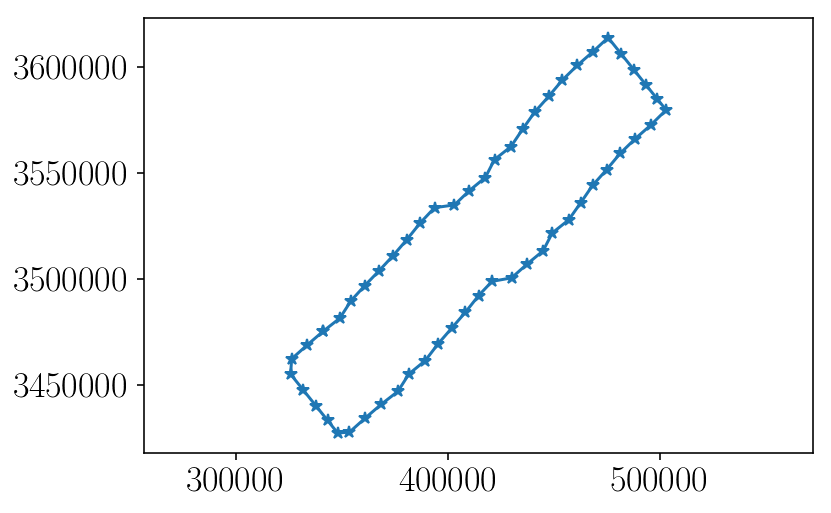

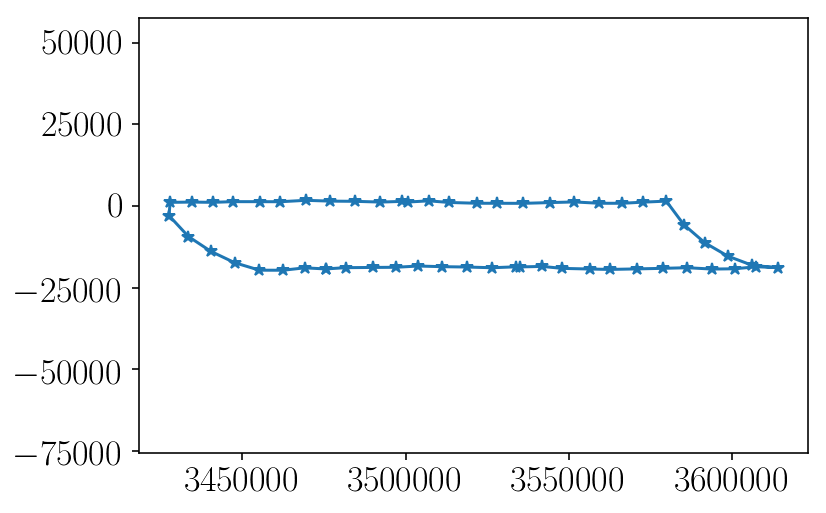

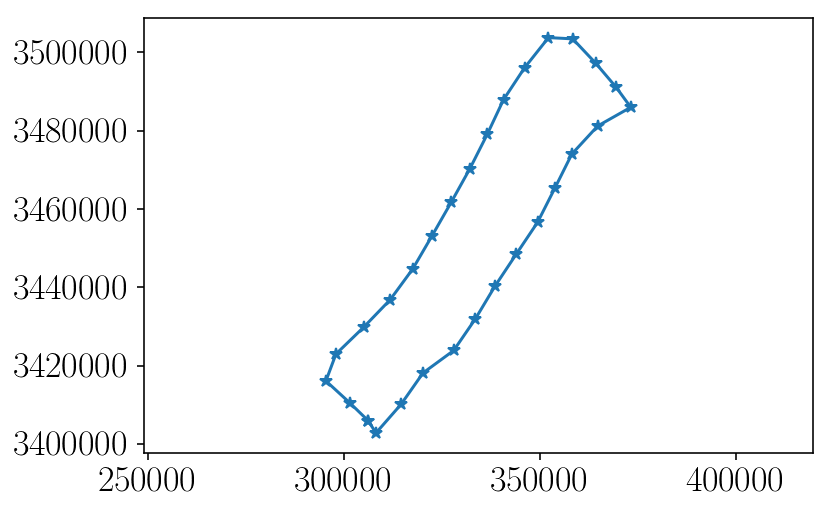

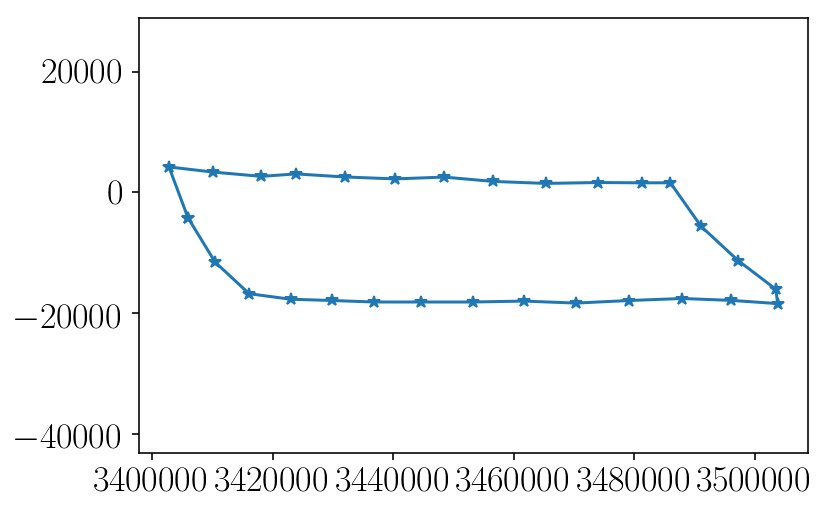

In [293]:
for i in range(len(orderings)):
    ordering = orderings[i]
    plt.figure()
    plt.plot(fault_m[0][ordering, 0], fault_m[0][ordering, 1], '-*')
    plt.axis('equal')
    plt.figure()
    plt.plot(fault_m[0][ordering, 1], fault_m[0][ordering, 2], '-*')
    plt.axis('equal')
    plt.show()

In [295]:
lonlat_pts = collect_dem.project(fault_m[0][:,0], fault_m[0][:,1], fault_m[0][:,2], proj, inverse = True)
bounds = get_dem_bounds(lonlat_pts)
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

48R
5 25 12
5 25 13


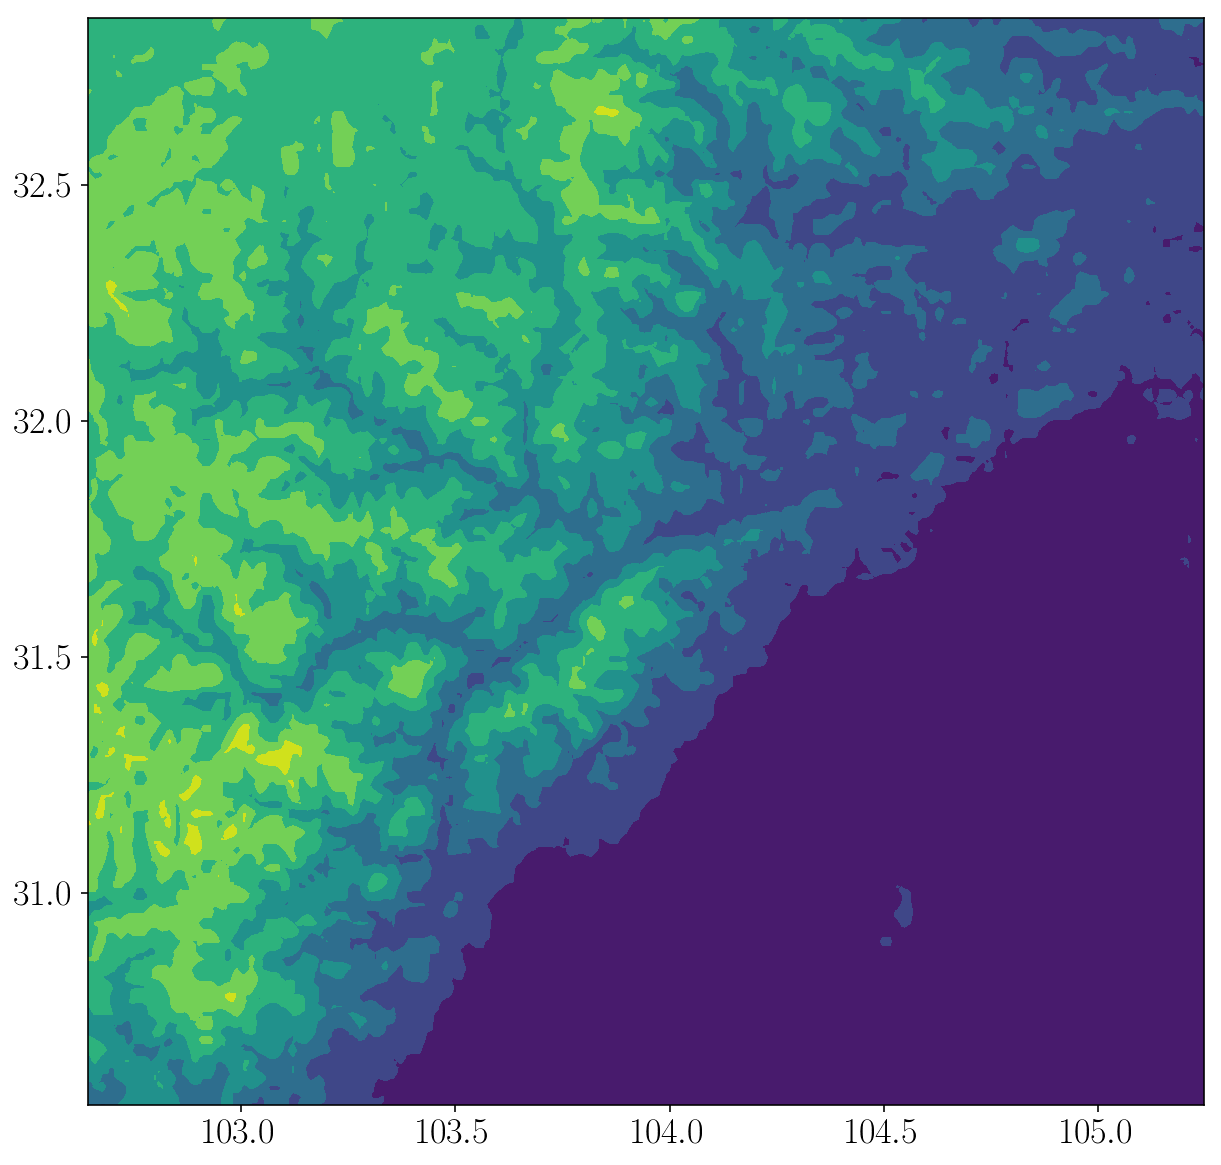

In [296]:
plt.figure(figsize = (10,10))
plt.tricontourf(LON, LAT, DEM)
plt.show()

In [297]:
proj_dem = collect_dem.project(LON, LAT, DEM, proj)

48R


In [298]:
fault_pt_elevations = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (fault_m[0][:,0], fault_m[0][:,1])
)

In [301]:
vertical_diff = fault_pt_elevations - fault_m[0][:,2]
below_surf = np.abs(vertical_diff) >= 1000
above_surf = np.logical_not(below_surf)

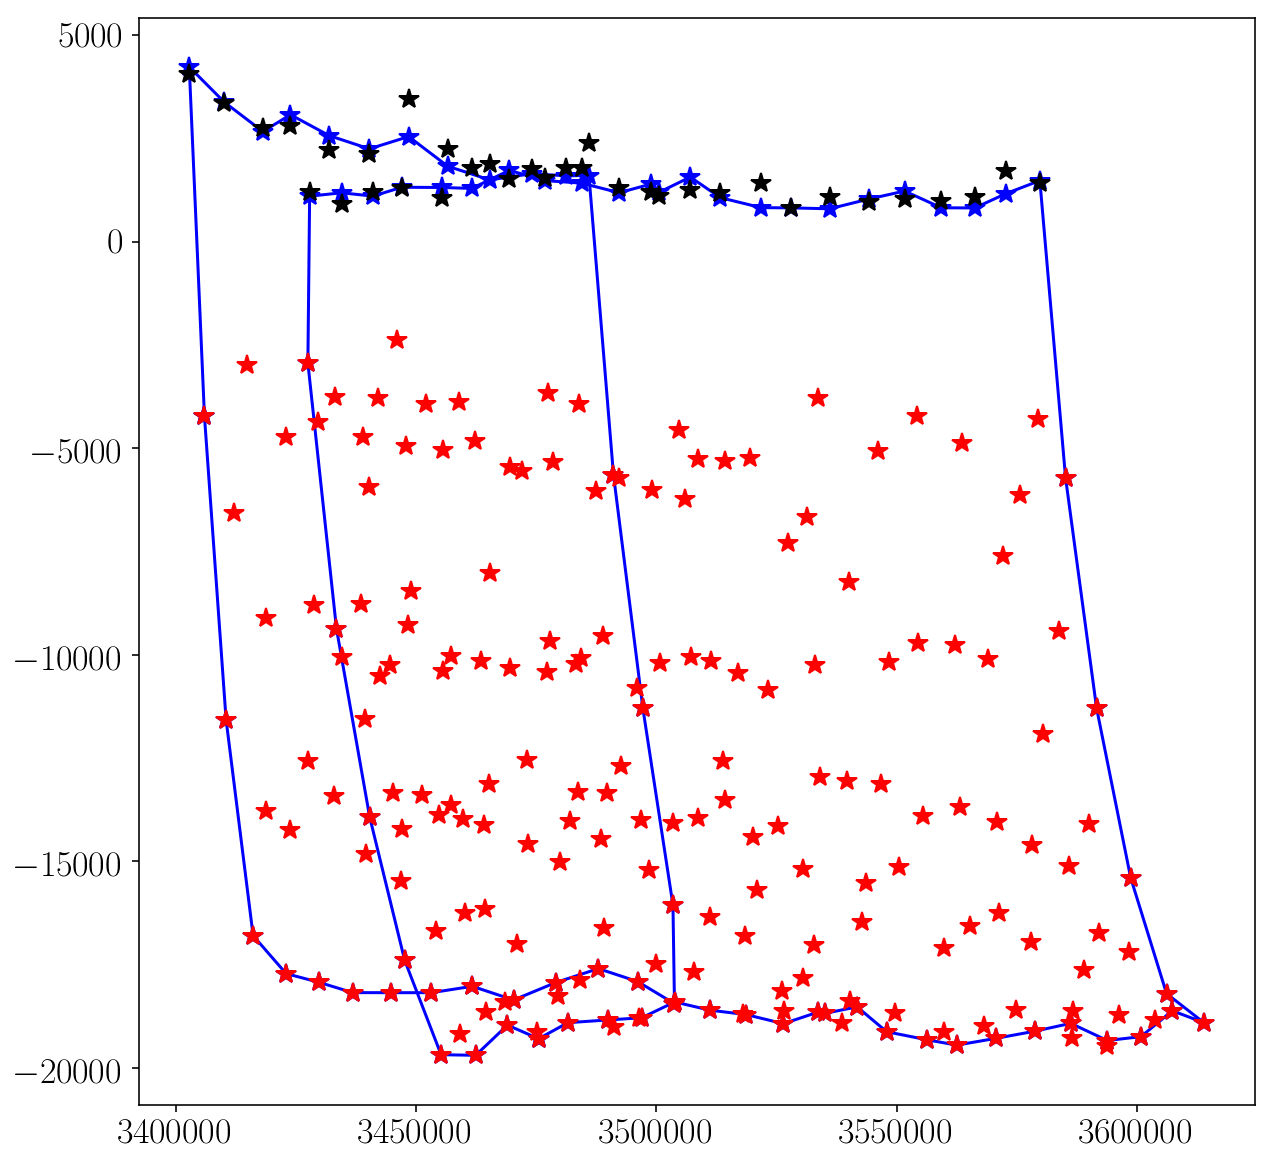

In [302]:
plt.figure(figsize = (10, 10))
for i in range(len(orderings)):
    plt.plot(fault_m[0][orderings[i], 1], fault_m[0][orderings[i], 2], 'b-*', markersize = 10)
plt.plot(fault_m[0][above_surf, 1], fault_pt_elevations[above_surf], 'k*', markersize = 10)
plt.plot(fault_m[0][below_surf, 1], fault_m[0][below_surf, 2], 'r*', markersize = 10, zorder = 10)
plt.show()

In [303]:
surface_fault_edges = []
for fault_edge in orderings:
    for i in range(len(fault_edge) - 1):
        vertex1 = fault_edge[i]
        vertex2 = fault_edge[i + 1]
        if below_surf[vertex1] or below_surf[vertex2]:
            continue
        surface_fault_edges.append((vertex1, vertex2))
surface_fault_edges = np.array(surface_fault_edges)

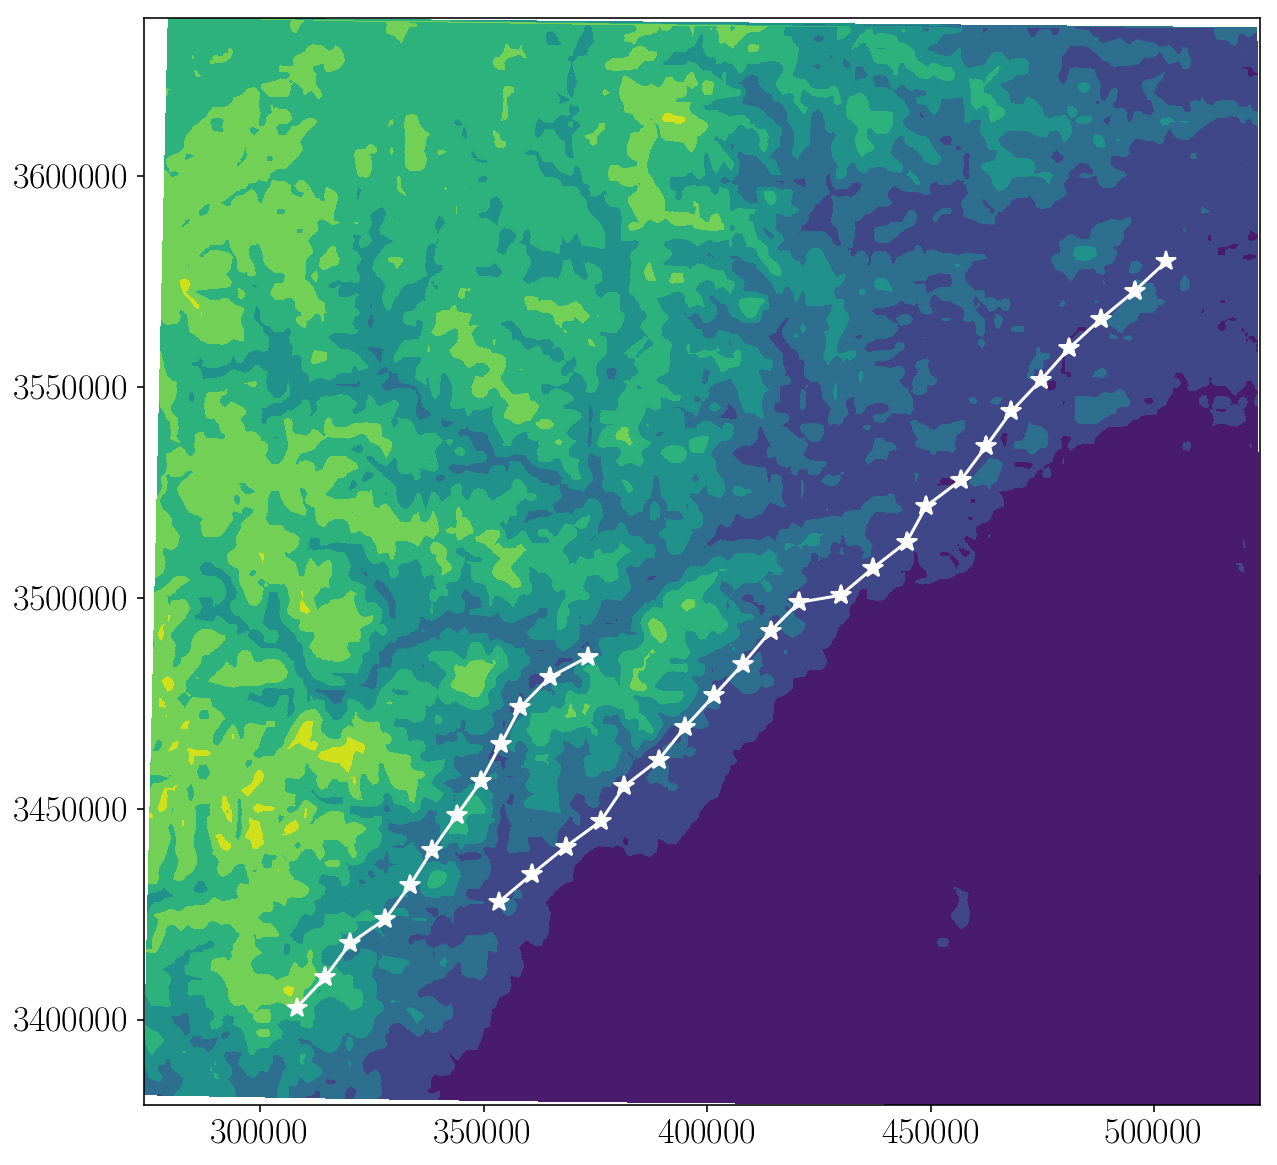

In [304]:
plt.figure(figsize = (10,10))
plt.tricontourf(proj_dem[:,0], proj_dem[:,1], proj_dem[:,2])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'w-*', markersize = 10)
plt.show()

In [305]:
upper_edge_idxs = np.unique(surface_fault_edges)
upper_edge_pts = fault_m[0][upper_edge_idxs,:]
upper_edge_pts.shape

(35, 3)

In [306]:
surf_center = np.mean(upper_edge_pts, axis = 0)
fault_L = np.max(np.sqrt(np.sum((upper_edge_pts - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 10
surf_center, fault_L

(array([  3.98409151e+05,   3.48312593e+06,   1.60278421e+03]),
 142192.37157032787)

In [307]:
geom = pygmsh.built_in.Geometry()

w = fault_L * 4
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
for edge in surface_fault_edges:
    for j in range(2):
        if edge[j] not in gmsh_pts:
            gmsh_pts[edge[j]] = geom.add_point(fault_m[0][edge[j]], mesh_size)
    line = geom.add_line(gmsh_pts[edge[0]], gmsh_pts[edge[1]])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

In [308]:
points, cells, pt_data, cell_data, field_data = pygmsh.generate_mesh(
    geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0
)

Info    : Running 'gmsh -2 -bin /tmp/tmphuzfvgdx.geo -o /tmp/tmpj921cqqs.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Wed Nov  1 11:14:15 2017
Info    : Reading '/tmp/tmphuzfvgdx.geo'...
Info    : Done reading '/tmp/tmphuzfvgdx.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve

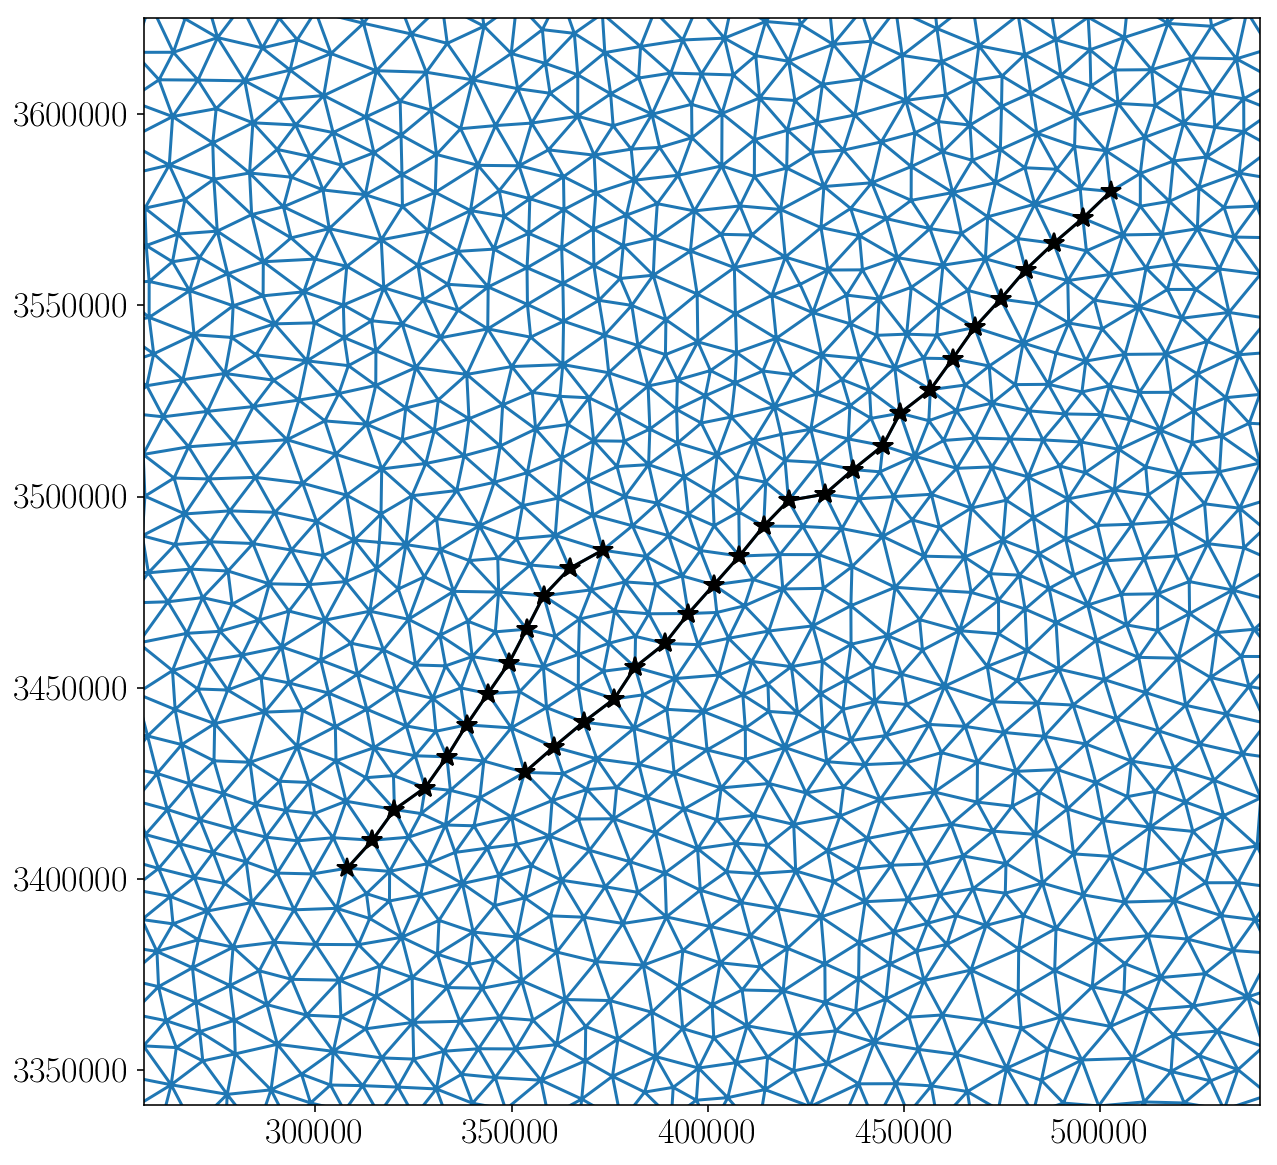

In [309]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'k-*', markersize = 10)
vW = 1 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

In [310]:
lonlat_pts = collect_dem.project(points[:,0], points[:,1], points[:,2], proj, inverse = True)
bounds = get_dem_bounds(lonlat_pts)
bounds

48R


(25.150509907854026,
 96.264352348334782,
 37.654578082684466,
 111.48261354726965)

In [311]:
proj_dem = collect_dem.project(*collect_dem.get_dem(zoom, bounds, n_dem_interp_pts), proj)

5 24 12
5 25 12
5 24 13
5 25 13
48R


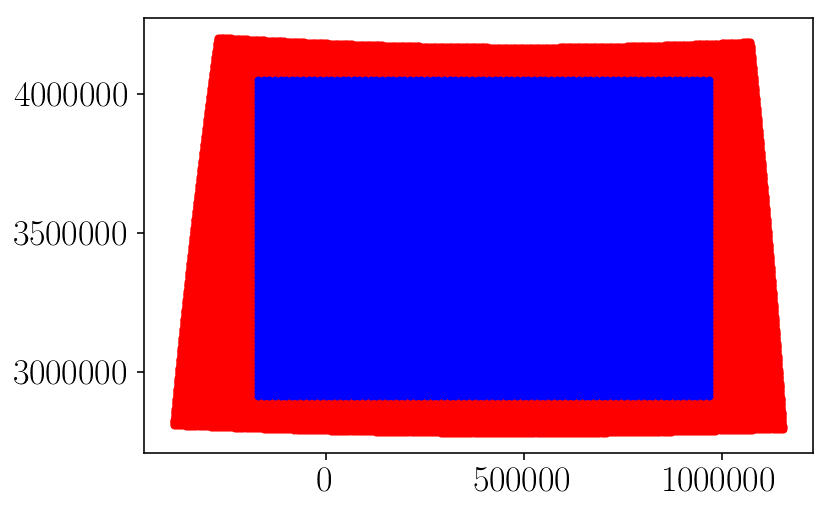

In [312]:
plt.plot(proj_dem[:,0], proj_dem[:,1], 'r.')
plt.plot(points[:,0], points[:,1], 'b.')
plt.show()

In [313]:
flat_surf_m = (points, cells['triangle'])

In [314]:
from tectosaur.mesh.refine import refine as core_refine

def refine(m, n):
    if n == 0:
        return m
    elif n == 1:
        return core_refine(m)
    else:
        return refine(core_refine(m), n - 1)

refinements = 1
refined_flat_surf_m = refine(flat_surf_m, refinements)
refined_fault_m = refine(fault_m, refinements)
refined_fault_pt_elevations = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_fault_m[0][:,0], refined_fault_m[0][:,1])
)
refined_vertical_diff = refined_fault_pt_elevations - refined_fault_m[0][:,2]
refined_below_surf = np.abs(refined_vertical_diff) >= 800
refined_above_surf = np.logical_not(refined_below_surf)

In [318]:
refined_flat_surf_m[0][:,2] = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_flat_surf_m[0][:,0], refined_flat_surf_m[0][:,1])
)
refined_fault_m[0][refined_above_surf,2] = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_fault_m[0][refined_above_surf,0], refined_fault_m[0][refined_above_surf,1])
)

In [319]:
from tectosaur.mesh.modify import concat
full_m = concat(refined_flat_surf_m, refined_fault_m)
full_m[0][:,2] *= 5
np.save('mesh.npy', full_m)

In [320]:
full_m[1].shape[0]

86368

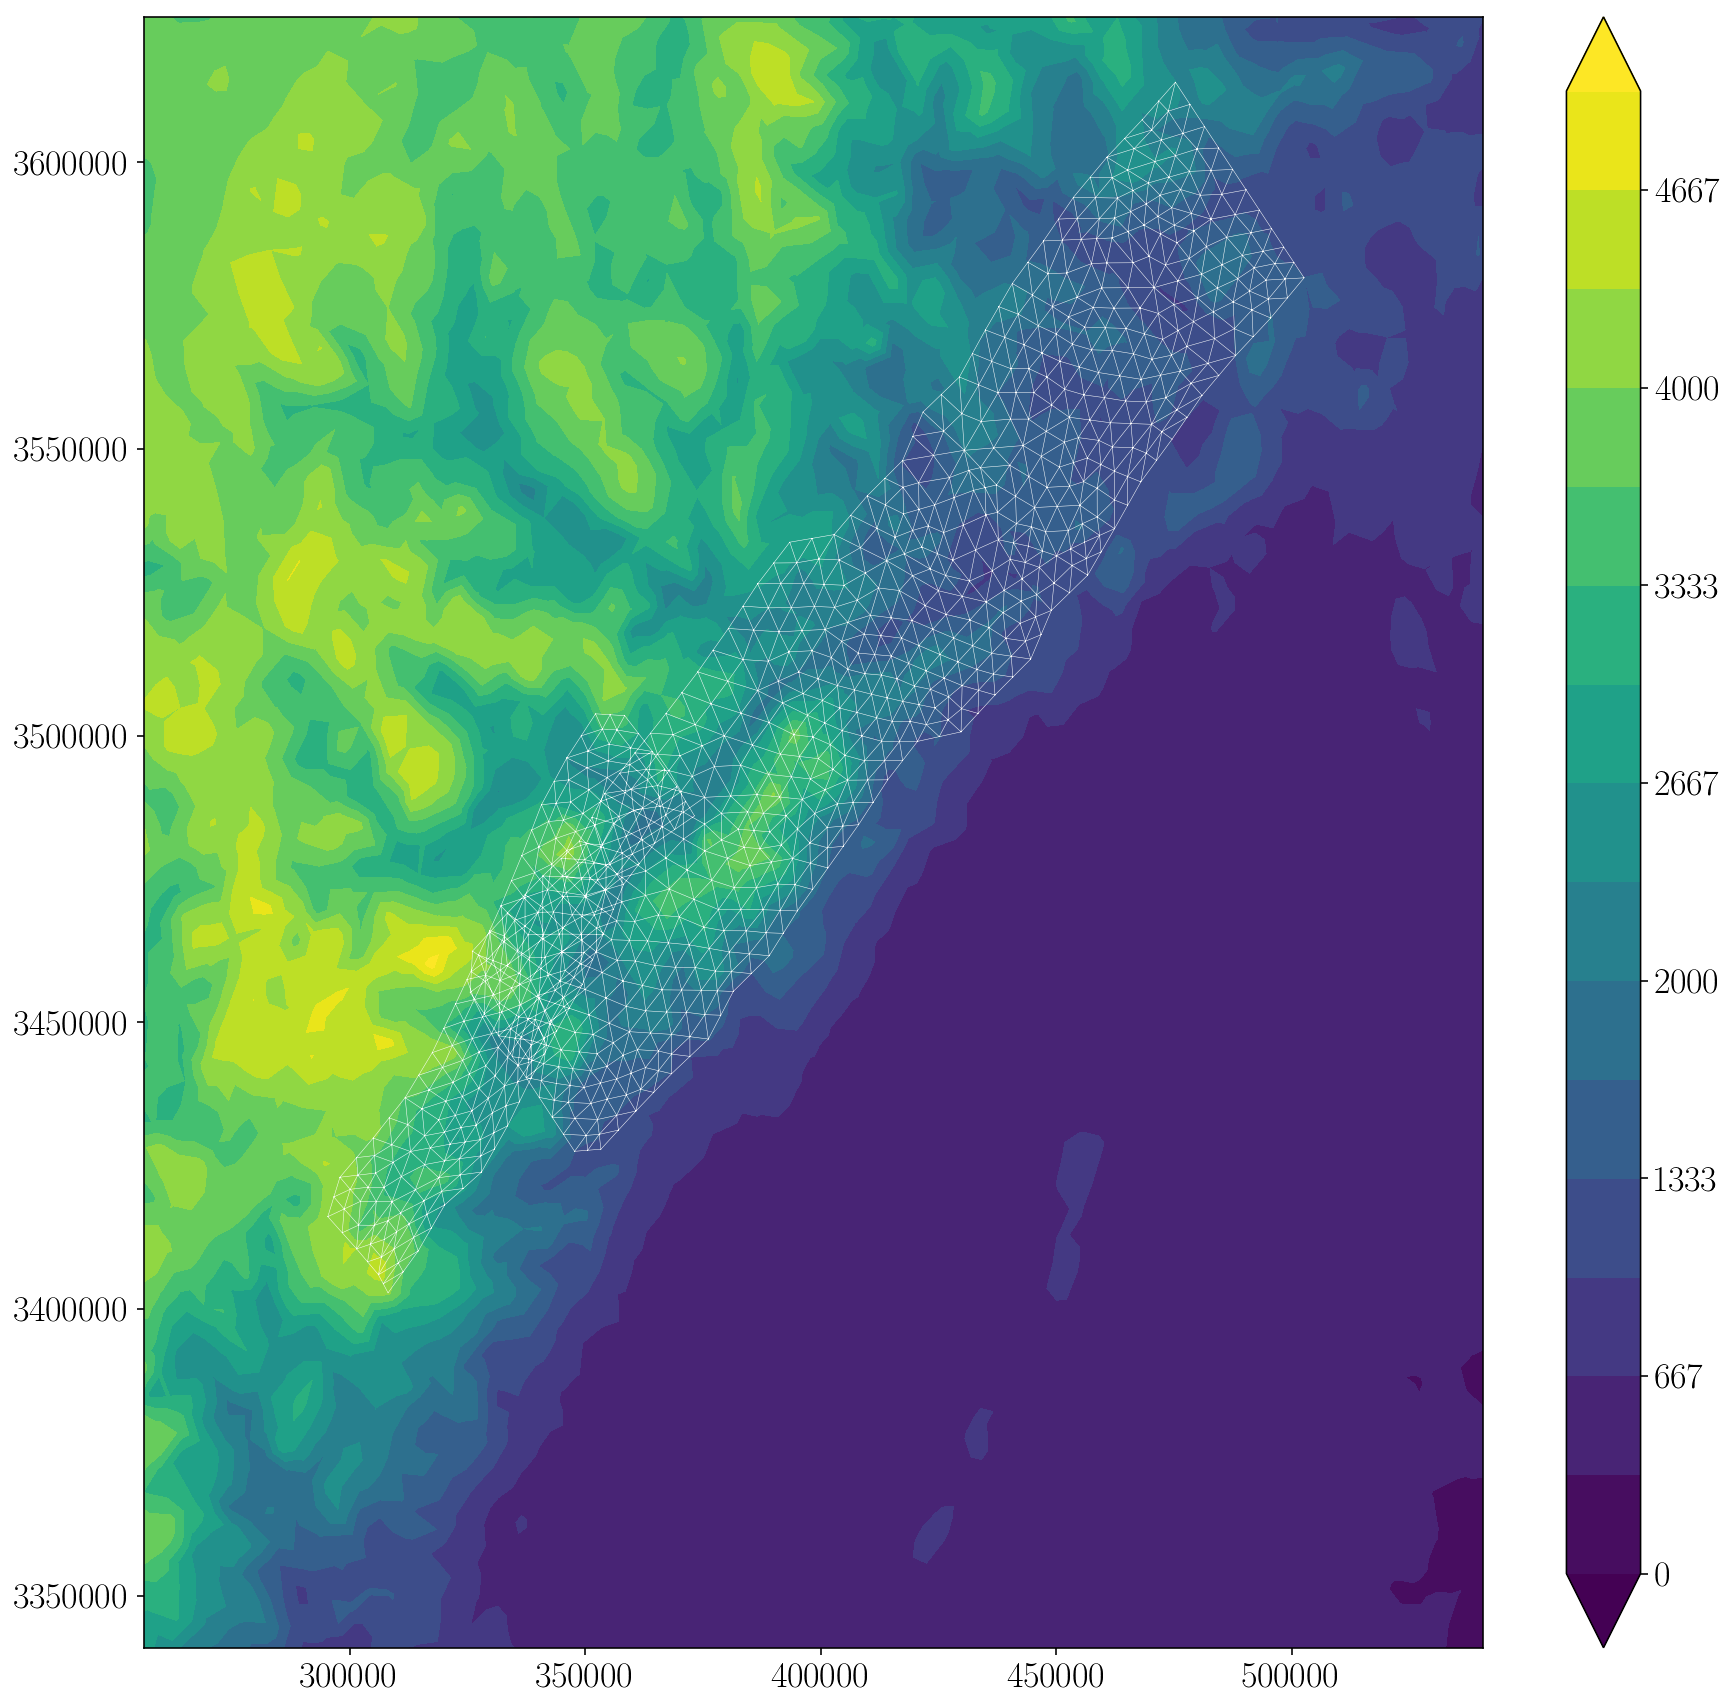

In [321]:
plt.figure(figsize = (15,15))
cntf = plt.tricontourf(refined_flat_surf_m[0][:,0], refined_flat_surf_m[0][:,1], refined_flat_surf_m[1], refined_flat_surf_m[0][:,2], levels = np.linspace(0, 5000, 16), extend = 'both')
plt.triplot(refined_fault_m[0][:,0], refined_fault_m[0][:,1], refined_fault_m[1], 'w-', linewidth = 0.25)
vW = 1 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.colorbar()
plt.show()

In [322]:
np.save('forward_model_meshes.npy', [refined_flat_surf_m, refined_fault_m])

In [15]:
refined_flat_surf_m, refined_fault_m = np.load('forward_model_meshes.npy')

In [30]:
from tectosaur.mesh.combined_mesh import CombinedMesh
from tectosaur.mesh.modify import remove_duplicate_pts
m = CombinedMesh([('surf', refined_flat_surf_m), ('fault', refined_fault_m)])
m.pts.shape[0], remove_duplicate_pts((m.pts,m.tris), threshold = 1e-7)[0].shape[0]

(43524, 43524)

In [5]:
import tectosaur_topo as tt
sm = 1.0
pr = 0.25
slip = np.array([[1, 0, 0] * refined_fault_m[1].size]).flatten()
m_pts, m_tris, fault_start_idx, soln = tt.solve_topo(
    refined_flat_surf_m, refined_fault_m, slip, sm, pr,
    preconditioner = 'ilu',
    solver_tol = 1e-15
)

[45734:INFO:tectosaur_topo.interface]
    tectosaur_topo.solve_topo configuration: 
{'float_type': <class 'numpy.float32'>,
 'fmm_mac': 3.0,
 'fmm_order': 150,
 'preconditioner': 'ilu',
 'pts_per_cell': 450,
 'quad_far_order': 2,
 'quad_mass_order': 3,
 'quad_near_order': 5,
 'quad_near_threshold': 2.0,
 'quad_vertadj_order': 6,
 'solver_tol': 1e-15,
 'verbose': True}
[55635:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/nearfield.cl
[56335:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0
[56967:DEBUG:tectosaur.util.gpu]
    compile took 1.3324799537658691
[56981:DEBUG:tectosaur.nearfield.nearfield_op]
        setup pairs integrator took 1.411585807800293
[56995:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- load table took 0.012696266174316406
[57281:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- get pts took 0.2851066589355469
[57291:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/table_lookup.cl
[57566:DEBUG:tectosaur.util.gpu]
    comp

[79905:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[79906:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[79907:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[79908:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[79909:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[79910:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[79911:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[79912:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[79913:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[79914:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.7827093601226807
[79925:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.010172367095947266
[79939:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.8464159965515137
[79960:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[79992:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.01704096794128418
[80005:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[80749:DEBUG:tectosaur.ops.

[155119:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.439544677734375
[155178:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[155179:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[155180:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[155181:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[155182:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[155183:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[155184:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[155184:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[155185:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[155186:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[155187:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.5155160427093506
[155204:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.015453338623046875
[155214:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.562894344329834
[155229:DEBUG:tectosaur_topo.solve]
    iteration # 5 took 1.153627634048462
[155230:DEBUG:tectosaur_top

[158883:DEBUG:tectosaur_topo.solve]
    residual: 1.6627228187354464e-09
[158948:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[158968:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.011591196060180664
[158976:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[159506:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.5294725894927979
[159508:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[159509:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[159509:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[159510:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[159511:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[159512:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[159513:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[159514:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[159515:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[159516:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[159517:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval t

[163242:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.014439105987548828
[163252:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.5564179420471191
[163268:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[163293:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.01483011245727539
[163301:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[163812:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.5106091499328613
[163813:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[163814:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[163815:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[163816:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[163817:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[163818:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[163819:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[163820:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[163820:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[163821

[167499:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[167500:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.5137593746185303
[167516:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.014560699462890625
[167526:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.5602755546569824
[167541:DEBUG:tectosaur_topo.solve]
    iteration # 15 took 1.1461443901062012
[167543:DEBUG:tectosaur_topo.solve]
    residual: 4.319160332004998e-12
[167625:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[167649:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.014424324035644531
[167658:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[168128:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.47000670433044434
[168151:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[168152:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[168153:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[168154:DEBUG:tectosaur.fmm.evaluator]


[171911:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[171912:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[171913:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[171914:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[171915:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[171915:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[171916:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[171917:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.5341463088989258
[171933:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.01453852653503418
[171943:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.5850496292114258
[171959:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[171983:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.0148162841796875
[171992:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[172498:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.5068135261535645
[172500:DEBUG:tectosaur.fmm.eval

[176171:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[176172:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[176173:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[176174:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[176175:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[176176:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[176177:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[176178:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[176179:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[176180:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[176180:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.5129697322845459
[176196:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.014624595642089844
[176206:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.5640275478363037
[176221:DEBUG:tectosaur_topo.solve]
    iteration # 22 took 1.15397047996521
[176223:DEBUG:tectosaur_topo.solve]
    residual: 1.7725311807882685e-14
[176306:DEBUG:tectosaur.ops.sparse_integra

[179970:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[179990:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.011692285537719727
[179998:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[180478:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.47999143600463867
[180493:DEBUG:tectosaur.fmm.evaluator]
    p2m took 0
[180494:DEBUG:tectosaur.fmm.evaluator]
    p2p took 0
[180495:DEBUG:tectosaur.fmm.evaluator]
    p2l took 0
[180496:DEBUG:tectosaur.fmm.evaluator]
    u2e took 0
[180496:DEBUG:tectosaur.fmm.evaluator]
    m2m took 0
[180497:DEBUG:tectosaur.fmm.evaluator]
    m2l took 0
[180498:DEBUG:tectosaur.fmm.evaluator]
    m2p took 0
[180499:DEBUG:tectosaur.fmm.evaluator]
    d2e took 0
[180500:DEBUG:tectosaur.fmm.evaluator]
    l2l took 0
[180501:DEBUG:tectosaur.fmm.evaluator]
    l2p took 0
[180502:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.5108633041381836
[180515:DEBUG:tectosaur.ops.sparse_integral_op]
 

In [6]:
np.save('soln.npy', [m_pts, m_tris, fault_start_idx, soln])

In [3]:
m_pts, m_tris, fault_start_idx, soln = np.load('soln.npy')

In [57]:
import scipy.spatial.distance
import scipy.spatial
import time
start = time.time()
kd = scipy.spatial.cKDTree(m_pts)
print()
print(time.time() - start)
start = time.time()
remove_duplicate_pts((m_pts,m_tris), threshold = 1e-7)
print(time.time() - start)
# def plot_distance_distribution(m):
    
#     dist = scipy.spatial.distance.cdist(m[0][:1000], m[0][:1000])
#     %matplotlib inline
#     plt.figure(figsize = (10,10))
#     plt.hist(np.log10(np.abs(dist[dist > 0])), bins = 50)
#     plt.show()
# plot_distance_distribution((m_pts, m_tris))

[[23789 23790]
 [25127 25188]
 [25037 25127]
 [25200 25242]
 [25007 25008]
 [24829 24891]]
0.04721570014953613
0.05707669258117676


In [4]:
surf_tris = m_tris[:fault_start_idx]
fault_tris = m_tris[fault_start_idx:]

In [5]:
relevant_pts = m_pts[fault_tris].reshape((-1, 3))
view_center = np.mean(relevant_pts, axis = 0)
fault_L = np.max(np.sqrt(np.sum((relevant_pts - view_center) ** 2, axis = 1)))
mesh_size = fault_L / 10
view_center, fault_L

(array([  394040.0493021 ,  3501158.46214971,   -11402.75292498]),
 139228.23770574032)

In [6]:
surf_verts = np.unique(surf_tris)
surf_fault_edges = []
for t in fault_tris:
    in_surf = []
    for d in range(3):
        if t[d] in surf_verts:
            in_surf.append(t[d])
    if len(in_surf) == 2:
        surf_fault_edges.append(in_surf)

In [7]:
connectivity = tri_connectivity_graph(m_tris)
fault_touching_pair = np.where(np.logical_and(
    connectivity.row < fault_start_idx, 
    connectivity.col >= fault_start_idx
))[0]

In [13]:
import importlib
import tectosaur.util.geometry
importlib.reload(tectosaur.util.geometry)
from tectosaur.util.geometry import unscaled_normals, tri_normal, tri_side

side = np.zeros(m_tris.shape[0])
shared_verts = np.zeros(m_tris.shape[0])

fault_surf_tris = m_pts[m_tris[connectivity.col[fault_touching_pair]]]
normals = unscaled_normals(fault_surf_tris)
normals /= np.linalg.norm(normals, axis = 1)[:,np.newaxis]
for i in range(fault_touching_pair.shape[0]):
    surf_tri_idx = connectivity.row[fault_touching_pair[i]]
    surf_tri = m_tris[surf_tri_idx]
    fault_tri = m_tris[connectivity.col[fault_touching_pair[i]]]
    
    which_side = tri_side(m_pts[fault_tri], m_pts[surf_tri])
    
    n_shared_verts = 0
    for d in range(3):
        if surf_tri[d] in fault_tri:
            n_shared_verts += 1
    
    if shared_verts[surf_tri_idx] < 2:
        side[surf_tri_idx] = int(which_side) + 1
        shared_verts[surf_tri_idx] = n_shared_verts

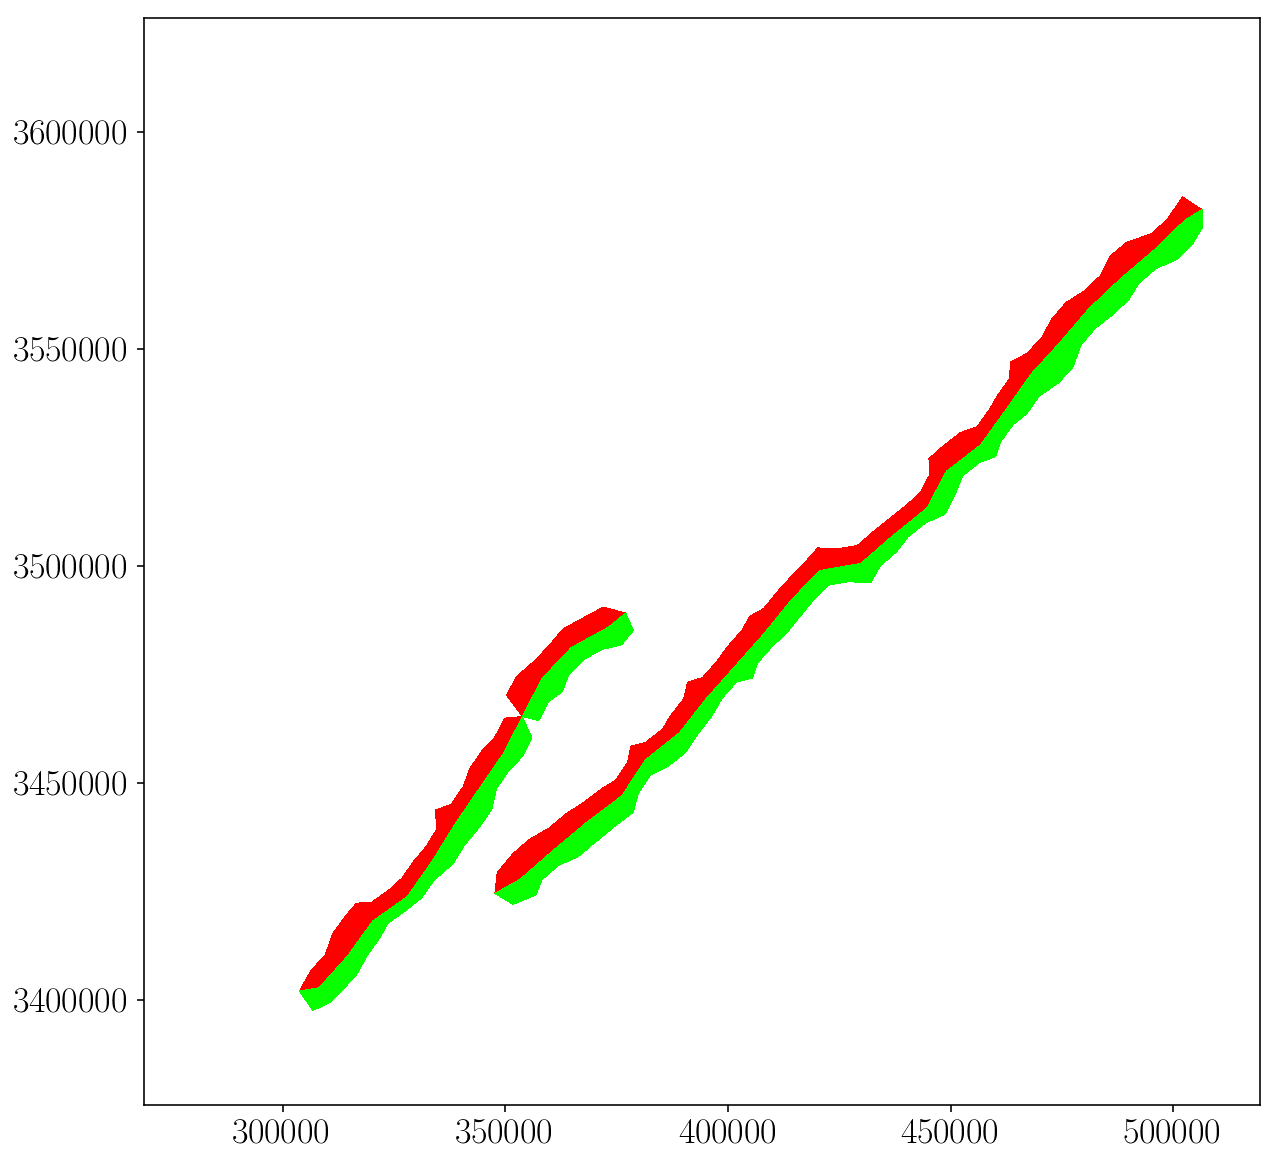

In [14]:
C = np.ones(m_pts.shape[0])
plt.figure(figsize = (10, 10))
for i in range(3):
    which_tris = m_tris[side == i + 1]
    if which_tris.shape[0] == 0:
        continue
    plt.tripcolor(m_pts[:,0], m_pts[:,1], which_tris, C * i, vmin = 0, vmax = 3, cmap = 'hsv')
vW = 0.9 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.show()

In [121]:
side_pts = [[], []]
side_vals = [[], []]
d = 0
soln_reshaped = soln.reshape((-1, 3, 3))[:, :, d]
for i in range(fault_touching_pair.shape[0]):
    surf_tri_idx = connectivity.row[fault_touching_pair[i]]
    surf_tri = m_tris[surf_tri_idx]
    fault_tri = m_tris[connectivity.col[fault_touching_pair[i]]]
    for d in range(3):
        if surf_tri[d] in fault_tri:# and m_pts[surf_tri[d]][0] > 375000:
            which_side = int(side[surf_tri_idx]) - 1
            side_pts[which_side].append(m_pts[surf_tri[d]])
            side_vals[which_side].append(soln_reshaped[surf_tri_idx,d])
side_pts = [np.array(side_pts[0]), np.array(side_pts[1])]
side_vals = [np.array(side_vals[0]), np.array(side_vals[1])]

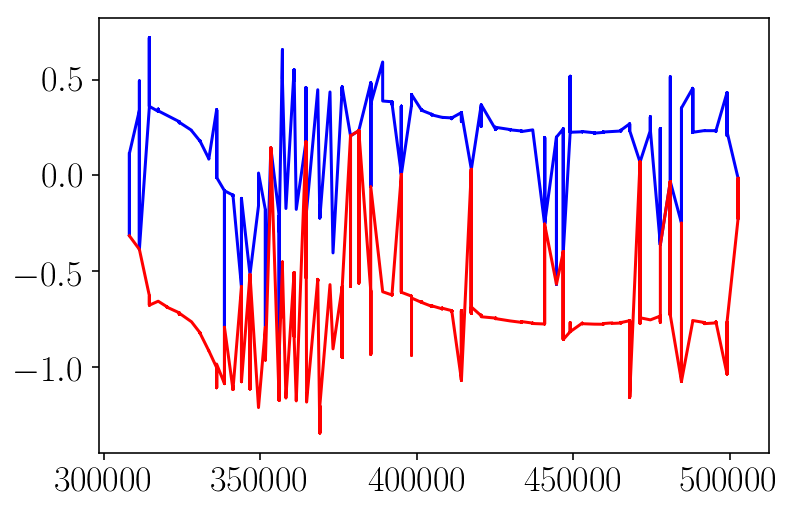

In [122]:
for i, c in [(0, 'b'), (1, 'r')]:
    order = np.argsort(side_pts[i][:,0])
    plt.plot(side_pts[i][order,0], side_vals[i][order], c)
plt.show()

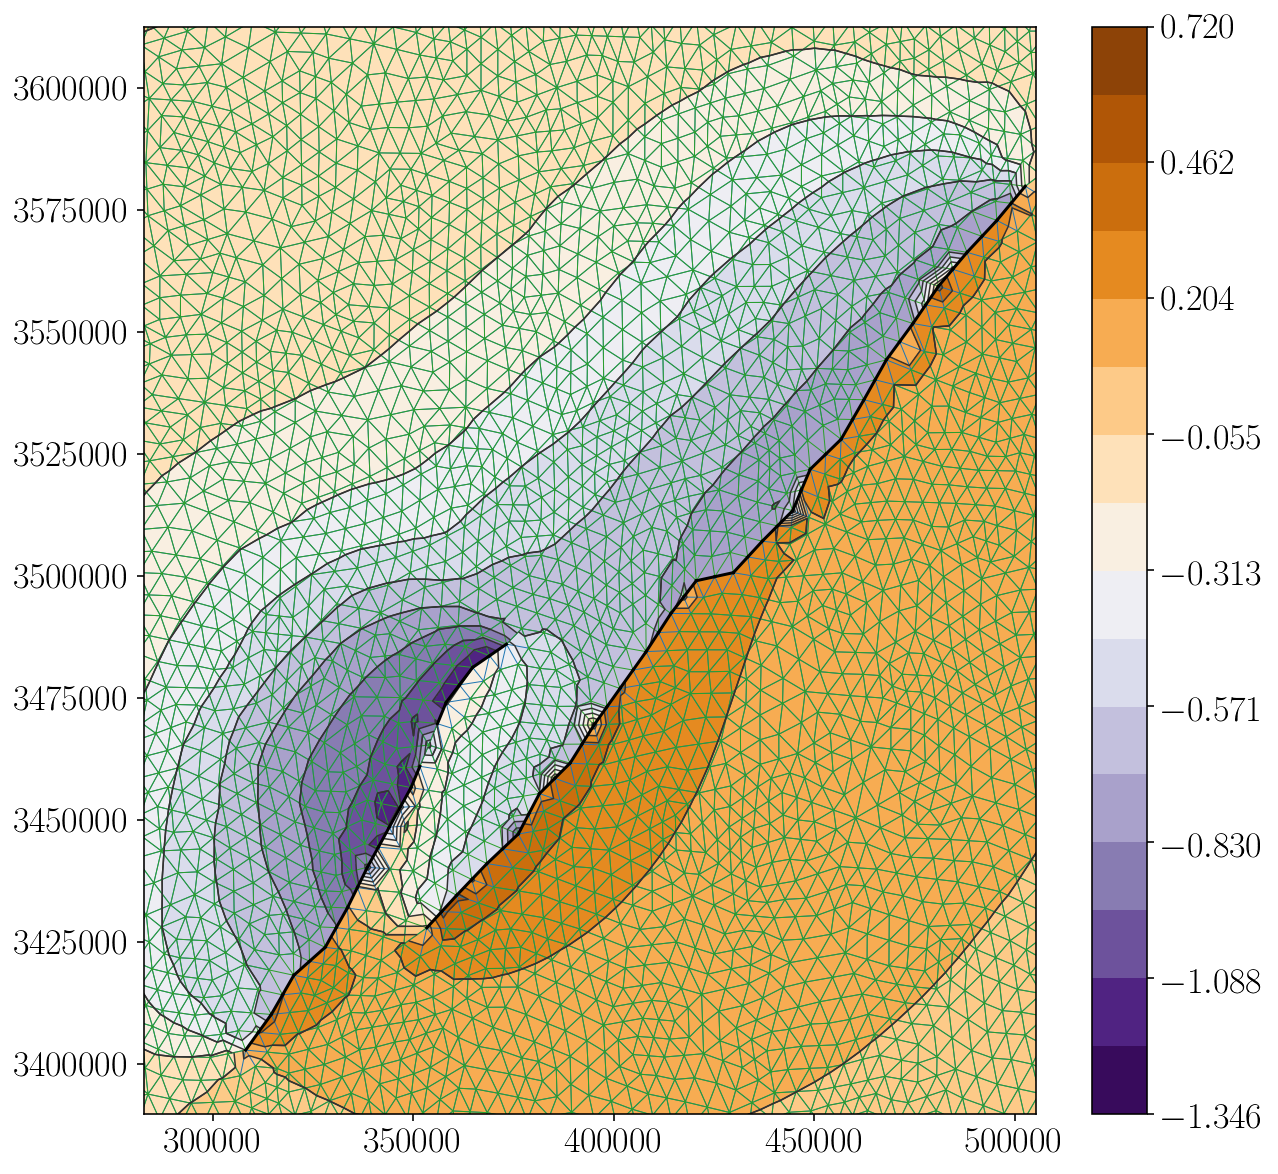

In [119]:
plt.figure(figsize = (10, 10))
d = 0
vmin = np.min(soln[soln < 1.0])
vmax = np.max(soln[soln < 1.0])
cmap = 'PuOr_r'
levels = np.linspace(vmin, vmax, 17)
for i in range(2):
    which_tris = np.where(np.logical_or(side[:fault_start_idx] == 0, side[:fault_start_idx] == i + 1))[0]
    reduced_m = remove_unused_pts((m_pts, m_tris[which_tris]))
    soln_vals = np.empty(reduced_m[0].shape[0])
    #soln_vals[reduced_m[1]] = np.sqrt(np.sum(soln.reshape((-1, 3, 3))[which_tris, :, :] ** 2, axis = 2))
    soln_vals[reduced_m[1]] = soln.reshape((-1, 3, 3))[which_tris, :, d]
    
#     triang = tri.Triangulation(reduced_m[0][:,0], reduced_m[0][:,1], triangles = reduced_m[1])
#     refiner = tri.UniformTriRefiner(triang)
#     interp = tri.LinearTriInterpolator(triang, soln_vals)
#     tri_refi, interp_vals = refiner.refine_field(field, triinterpolator = interp, subdiv = 2)
#     cntf = plt.tricontourf(tri_refi, interp_vals, cmap = cmap, levels = levels)
#     plt.tricontour(
#         tri_refi, interp_vals,
#         levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
#     )
    
    cntf = plt.tricontourf(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        cmap = cmap, 
        levels = levels
    )
    plt.tricontour(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        levels = levels, 
        colors = '#333333', linestyles = 'solid', linewidths = 0.75
    )
    plt.triplot(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], linewidth = 0.5
    )

# elev_levels = np.linspace(np.min(m_pts[surf_tris][:,:,2]), np.max(m_pts[surf_tris][:,:,2]), 11)
# plt.tricontour(
#     m_pts[:,0], m_pts[:,1], surf_tris, m_pts[:,2],
#     levels = elev_levels, 
#     colors = '#999999', linestyles = 'solid', linewidths = 2.0
# )
for edge in surf_fault_edges:
    pts = m_pts[edge]
    plt.plot(pts[:,0], pts[:,1], 'k-', markersize = 10)
    
plt.colorbar(cntf)
vW = 0.8 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.savefig('wenchuan_forward.pdf')
plt.show()